# Putting It All Together: A Realistic Example

In this section we're going to work through a realistic example of a deep learning workflow. We'll be working with a smallish dataset featuring different kinds of flowers from Kaggle. We're going to apply data augmentation to synthetically expand the size of our dataset. And we'll attempt transfer learning using networks pretrained on the ImageNet dataset, which includes some flower species already. 

In [1]:
# All of this should look familiar from previous notebooks:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageOps

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, image as keras_image
from keras.utils import to_categorical

# Our function to load an image from a path and fix it up, but 
# modified slightly to accomodate MobileNetV2.
def load_maintain_aspect_ratio(input_image_path, target_size):
    image = Image.open(input_image_path)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    image = image.resize(target_size)
    
    # Last thing: we're going to scale all the default (0-255) RGB
    # values to be floats from 0-1. If we do not do this in some cases
    # the generators we use below wrongly interpret the int's as floats
    # and clip values greater than 1. It's a strange bug you wouldn't expect
    # so it's better to just handle it here!
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # The preprocess function from MobileNetV2
    # It expects a numpy array with RGB values between 0-255
    return preprocess_input(image_data)


# Our recurring plot function.
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

Using TensorFlow backend.


In [23]:
# Some constants:
# 224x224 is MobileNetV2's default, so lets stick with it
image_size = 224
batch_size = 32
validation_split = 0.2

# Start small, for the sake of learning speed.
num_epochs = 5

# The dataset is too large to reasonably redistribute as part of this repository, so you will
# have to download it separately from: https://www.kaggle.com/alxmamaev/flowers-recognition/

# The download as a flowers folder, this variable should point to the 
# loccation of that folder. Inside that folder there should be 5 folders
# each named for the type of flower.
flower_dataset_directory = 'flowers_dataset/flowers/'

# The image classes
classes = {
    'daisy': 0, 
    'dandelion': 1, 
    'rose': 2,
    'sunflower': 3,
    'tulip': 4
}

# Process all of the images into an array
images = []
labels = []
for subdir in classes.keys():
    current_location = os.path.join(flower_dataset_directory, subdir)
    print(f'Processing {subdir}')
    sub_dir_count = 0
    for file in os.listdir(current_location):
        try:
            image = load_maintain_aspect_ratio(os.path.join(current_location, file), (image_size, image_size))
            images.append(image)
            labels.append(classes[subdir])
            sub_dir_count += 1
        except:
            print(f'Failed to load image: {subdir}/{file}. Ignored it.')
    
    print(f'Found {sub_dir_count} images of type {subdir}')

# Just double check.
assert len(images) == len(labels)

# This is a little bit crude, but we'll just randomly select each image/label pair
# to be in the validation set based on our validation split. We could take greater
# care here to ensure that the right amount are represented from each class
# but it will probably be okay...
x_train = []
y_train = []

x_validation = []
y_validation = []

for image, label in zip(images, labels):
    if np.random.random() > validation_split:
        x_train.append(image)
        y_train.append(label)
    else:
        x_validation.append(image)
        y_validation.append(label)

# Properly format the images into a np array
x_train = np.array(x_train)
x_validation = np.array(x_validation)

# Make the labels one-hot encoded:
y_train = to_categorical(y_train, len(classes))
y_validation = to_categorical(y_validation, len(classes))
            
print(f'Loaded {len(images)}')
print(f'Training size: {len(x_train)}, validation size: {len(x_validation)}')

Processing daisy
Found 769 images of type daisy
Processing dandelion
Failed to load image: dandelion/flickr.py. Ignored it.
Failed to load image: dandelion/flickr.pyc. Ignored it.
Failed to load image: dandelion/run_me.py. Ignored it.
Found 1052 images of type dandelion
Processing rose
Found 784 images of type rose
Processing sunflower
Found 734 images of type sunflower
Processing tulip
Found 984 images of type tulip
Loaded 4323
Training size: 3495, validation size: 828


In [24]:
# Lots of possible augmentation to the training data
# hopefully allowing us to avoid overfitting
train_generator = ImageDataGenerator(    
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10, 
    zoom_range=0.5, 
    fill_mode='constant', 
    cval=0.0
)

# Don't transform the validation images.
validation_generator = ImageDataGenerator()

# Fit them both, best practice
train_generator.fit(x_train)
validation_generator.fit(x_validation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3495, 224, 224, 3)
(828, 224, 224, 3)
(3495, 5)
(828, 5)


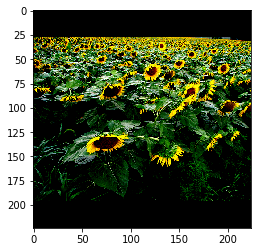

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


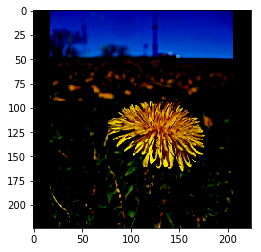

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


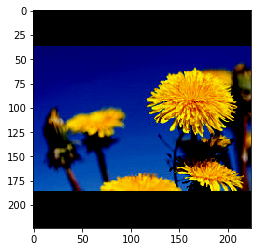

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


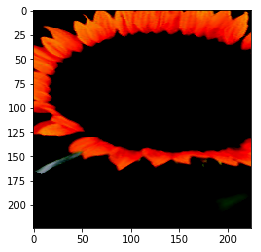

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


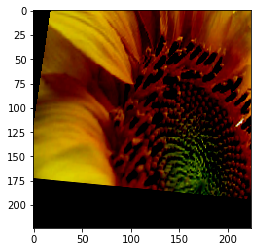

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


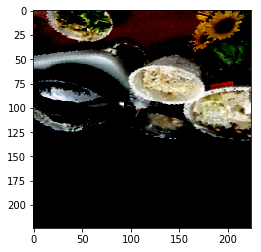

In [32]:
# Lets do some sanity checking:
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

# View a couple, validations are never augmented
for _ in range(3):
    plt.imshow(next(validation_generator.flow(x_validation))[0])
    plt.show()
    
# But training data is
for _ in range(3):
    plt.imshow(next(train_generator.flow(x_train))[0])
    plt.show()

Epoch 1/5
109/109 [==============================] - 187s 2s/step - loss: 1.0293 - acc: 0.6069 - val_loss: 0.8430 - val_acc: 0.6425
Epoch 2/5
109/109 [==============================] - 179s 2s/step - loss: 0.6754 - acc: 0.7524 - val_loss: 0.7388 - val_acc: 0.6947
Epoch 3/5
109/109 [==============================] - 179s 2s/step - loss: 0.6286 - acc: 0.7667 - val_loss: 0.7084 - val_acc: 0.7173
Epoch 4/5
109/109 [==============================] - 179s 2s/step - loss: 0.5962 - acc: 0.7803 - val_loss: 0.5793 - val_acc: 0.7802
Epoch 5/5
109/109 [==============================] - 182s 2s/step - loss: 0.5711 - acc: 0.7861 - val_loss: 0.6055 - val_acc: 0.7802


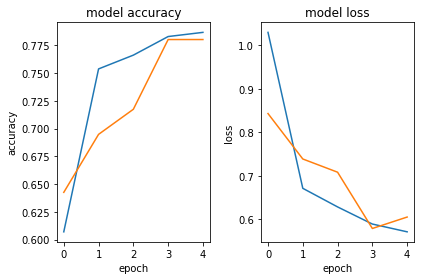

In [33]:
# Loading our pretrained mobilenet 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Make a very simple new classifier
old_top = base_model.output
old_top = GlobalAveragePooling2D()(old_top)
new_top = Dense(len(classes), activation='softmax')(old_top)
model = Model(inputs=base_model.input, outputs=new_top)

# We have a small amount of data, but the data is pretty similar
# to imagenet, which does train on many flower images, so we can
# expect the existing weights to be pretty good. Freeze all. 
for layer in base_model.layers:
    layer.trainable = False

# Go for it!
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=num_epochs,
                    validation_data=validation_generator.flow(x_validation, y_validation),
                    validation_steps=len(x_validation) // batch_size
)

plot_training_history(history, model)

Epoch 1/5
109/109 [==============================] - 217s 2s/step - loss: 0.7152 - acc: 0.7494 - val_loss: 0.7214 - val_acc: 0.8187
Epoch 2/5
109/109 [==============================] - 213s 2s/step - loss: 0.5055 - acc: 0.8178 - val_loss: 0.8072 - val_acc: 0.8065
Epoch 3/5
109/109 [==============================] - 206s 2s/step - loss: 0.4589 - acc: 0.8390 - val_loss: 0.8617 - val_acc: 0.8065
Epoch 4/5
109/109 [==============================] - 213s 2s/step - loss: 0.3871 - acc: 0.8589 - val_loss: 0.7875 - val_acc: 0.8028
Epoch 5/5
109/109 [==============================] - 256s 2s/step - loss: 0.3758 - acc: 0.8568 - val_loss: 0.5818 - val_acc: 0.8593


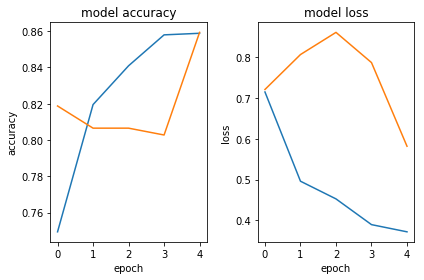

In [34]:
# Things are going great! Lets unfreeze some of our model's layers and see if "forgetting" 
# some of the stuff our network learned about dogs, buildings, and waterbottles can
# improve our results further... 

# This number was chosen specifically for MobileNetV2, it is the 
# start of the 15th block. 
for layer in model.layers[134:]:
    layer.trainable = True

# Recompile to ensure the layers get set to trainable
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=num_epochs,
                    validation_data=validation_generator.flow(x_validation, y_validation),
                    validation_steps=len(x_validation) // batch_size
)

plot_training_history(history, model)

Right on, things still look great and continue to improve! After this maybe we could get an even bigger dataset and buy some cloud compute time to train the model for longer... 

Epoch 1/30
109/109 [==============================] - 242s 2s/step - loss: 0.3351 - acc: 0.8736 - val_loss: 0.6846 - val_acc: 0.8488
Epoch 2/30
109/109 [==============================] - 213s 2s/step - loss: 0.3299 - acc: 0.8839 - val_loss: 0.7785 - val_acc: 0.8379
Epoch 3/30
109/109 [==============================] - 209s 2s/step - loss: 0.3164 - acc: 0.8811 - val_loss: 1.7444 - val_acc: 0.7588
Epoch 4/30
109/109 [==============================] - 210s 2s/step - loss: 0.3239 - acc: 0.8856 - val_loss: 1.9391 - val_acc: 0.7236
Epoch 5/30
109/109 [==============================] - 210s 2s/step - loss: 0.3077 - acc: 0.8902 - val_loss: 1.5350 - val_acc: 0.7563
Epoch 6/30
109/109 [==============================] - 210s 2s/step - loss: 0.2789 - acc: 0.9002 - val_loss: 0.9182 - val_acc: 0.8204
Epoch 7/30
109/109 [==============================] - 210s 2s/step - loss: 0.2535 - acc: 0.9091 - val_loss: 0.8975 - val_acc: 0.8304
Epoch 8/30
109/109 [==============================] - 207s 2s/step - 

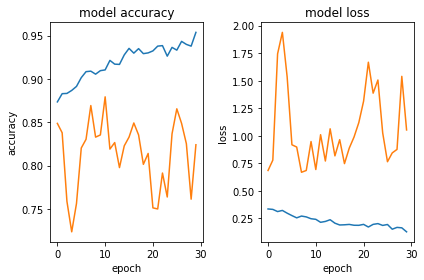

In [35]:
# I ran this one overnight, just for fun, and to see if we started to overfit
history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=30,
                    validation_data=validation_generator.flow(x_validation, y_validation),
                    validation_steps=len(x_validation) // batch_size
)

plot_training_history(history, model)

I love this result — we do see validation continue to diverge from training, implying we are overfitting even with the augmentation tactics. But we also see that validation is really unstable. Sometimes we're getting lucky, but some of the adjustments are hurting us. We probably need more data to improve much more. 